In [62]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2

# --- Load k-grid ---
k_full = emulator.modes.astype(np.float32)
k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0]
k = k_full[k_idx]
print (np.shape(k_idx))


# --- Random cosmology ---
rng = np.random.default_rng(seed=42)
As = rng.uniform(1.7e-9, 2.5e-9)
ns = rng.uniform(0.92, 1.00)
Omb = rng.uniform(0.04, 0.06)
Omm = rng.uniform(0.24, 0.40)
h = rng.uniform(0.61, 0.73)
mnu = 0.0
w = -1.0
wa = 0.0

cosmo_dict = {
    'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
    'mnu': mnu, 'w': w, 'wa': wa,
}

# --- Setup emulator inputs ---
omega_b = Omb * h**2
omega_cdm = (Omm - Omb) * h**2
ln_10_A_s = np.log(1e10 * As)

# --- Initialize emulator ---
emulator = CosmoPowerJAX(probe="mpk_lin")

def get_nonlinear_pk(z):
    inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
    pk_lin = emulator.predict(inp)[k_idx]
    _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
    pk_nl = pk_lin * boost[0]
    return pk_nl

# --- Compute nonlinear P(k) ---
pk_nl_z5 = get_nonlinear_pk(5.0)
pk_nl_z45 = get_nonlinear_pk(4.5)
pk_nl_z0 = get_nonlinear_pk(0.0)

# --- Print example values ---
print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])




(262,)
Nonlinear P(k) at z = 5: [4276.6577 4279.51   4278.6187 4273.869  4265.1694]
Nonlinear P(k) at z = 0: [100392.38  100443.484 100408.11  100284.055 100068.805]


In [66]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import os

# --- Load model ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=265, out_size=262, width_size=512, depth=4, key=dummy_key)

    def __call__(self, P, H, rho, z):
        x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
        return self.mlp(x)

# Load the trained model
model_path = "/srv/scratch3/taylor.4264/odd_emu/models_final/learned_model_logpk_0.eqx"
model = RHS()
model_params = eqx.tree_deserialise_leaves(model_path, model)
model = eqx.combine(model_params, model)

# --- Load k and set up random cosmology ---
k_full = emulator.modes.astype(np.float32)
k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0]
k = k_full[k_idx]
print (np.shape(k_idx))
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2

emulator = CosmoPowerJAX(probe="mpk_lin")

rng = np.random.default_rng(42)
As = rng.uniform(1.7e-9, 2.5e-9)
ns = rng.uniform(0.92, 1.00)
Omb = rng.uniform(0.04, 0.06)
Omm = rng.uniform(0.24, 0.40)
h = rng.uniform(0.61, 0.73)

cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
omega_b = Omb * h**2
omega_cdm = (Omm - Omb) * h**2
ln_10_A_s = np.log(1e10 * As)

def get_nl_logpk(z):
    inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
    pk_lin = emulator.predict(inp)[k_idx]
    _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
    pk_nl = pk_lin * boost[0]
    return jnp.log(pk_nl.astype(jnp.float32))

# --- Initial condition at z = 5 ---
z0 = 5.0
z1 = 0.0
ts = jnp.linspace(z0, z1, 100)
logpk0 = get_nl_logpk(z0)

# --- Define H(z) and rho_m(z) ---
G = 4.30091e-9  # Mpc⋅Msun⁻¹⋅(km/s)²
def Hz_func(z):
    a = 1.0 / (1.0 + z)
    Ez2 = Omm * (1 + z) ** 3 + (1 - Omm) * a ** (-3 * (1 + (-1.0)))
    return 100.0 * h * jnp.sqrt(Ez2)

def rho_m_func(z):
    Hz = Hz_func(z)
    rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
    return Omm * rho_crit

# --- Load training normalization data ---
data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
Hz_all = np.load(os.path.join(data_dir, "Hz.npy"))
rho_m_all = np.load(os.path.join(data_dir, "rho_m.npy"))

# --- Compute normalization constants from training set ---
H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_all = np.log10(rho_m_all + 1e-30)
log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

print("H_mean, H_std =", H_mean, H_std)
print("log_rho_mean, log_rho_std =", log_rho_mean, log_rho_std)

def H_norm(z):
    return (Hz_func(z) - H_mean) / H_std

def rho_norm(z):
    return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

# --- RHS function for ODE ---
def rhs(z, logP, args):
    model, = args
    H_z = jnp.atleast_1d(H_norm(z))
    rho_z = jnp.atleast_1d(rho_norm(z))
    return model(logP, H_z, rho_z, z)

# --- Solve the ODE ---
term = ODETerm(rhs)
solver = Tsit5()
saveat = SaveAt(ts=ts)

sol = diffeqsolve(
    term,
    solver,
    t0=z0,
    t1=z1,
    dt0=-1e-2,  # z decreasing
    y0=logpk0,
    args=(model,),
    saveat=saveat
)

logpk_sol = sol.ys  # shape (n_steps, 262)
pk_sol = jnp.exp(logpk_sol)

print(f"Integrated nonlinear P(k) shape: {pk_sol.shape}")
print(f"P(k, z=5): {pk_sol[0, :5]}")
print(f"P(k, z=0): {pk_sol[-1, :5]}")

(262,)
H_mean, H_std = 269.02625 131.01848
log_rho_mean, log_rho_std = 11.671948 0.48913768
Integrated nonlinear P(k) shape: (100, 262)
P(k, z=5): [4276.656  4279.5117 4278.618  4273.871  4265.17  ]
P(k, z=0): [92716.67  92023.13  94276.49  93937.336 93348.11 ]


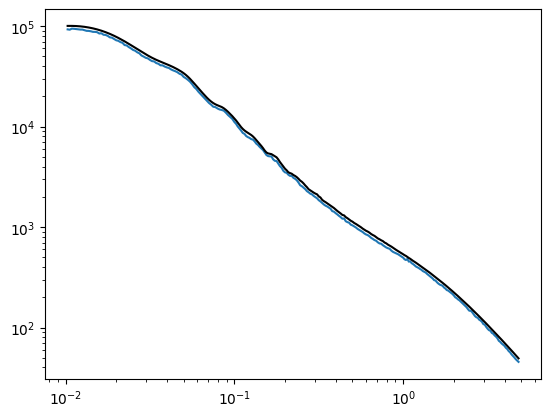

In [67]:
from matplotlib import pyplot as plt
plt.plot(k,pk_sol[-1])
plt.plot(k,pk_nl_z0, color = 'k')
plt.xscale('log')
plt.yscale('log')

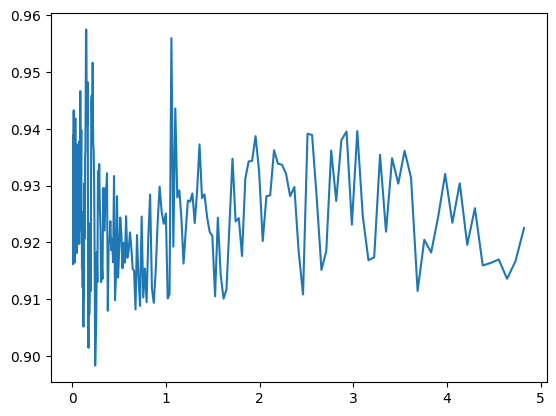

In [69]:
plt.plot(k,pk_sol[-1]/ pk_nl_z0)